In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Number of training samples: 1322
Number of validation samples: 60
Number of test samples: 150
Class names: ['Healthy', 'Powdery', 'Rust']
Training CNN model...
Epoch 1/10
Train Loss: 25.5126, Train Acc: 0.6354
Val Loss: 6.8840, Val Acc: 0.7000
----------------------------------------
Epoch 2/10
Train Loss: 2.1774, Train Acc: 0.8306
Val Loss: 2.7776, Val Acc: 0.7667
----------------------------------------
Epoch 3/10
Train Loss: 0.5681, Train Acc: 0.8911
Val Loss: 0.6304, Val Acc: 0.8333
----------------------------------------
Epoch 4/10
Train Loss: 0.2098, Train Acc: 0.9312
Val Loss: 0.4730, Val Acc: 0.8500
----------------------------------------
Epoch 5/10
Train Loss: 0.2007, Train Acc: 0.9304
Val Loss: 0.5603, Val Acc: 0.8167
----------------------------------------
Epoch 6/10
Train Loss: 0.1216, Train Acc: 0.9629
Val Loss: 0.4198, Val Acc: 0.8833
----------------------------------------
Epoch 7/10
Train Loss: 0.1514, Train Acc: 0.9493
Val Loss: 0.3839, Val Acc: 0.8500
------------

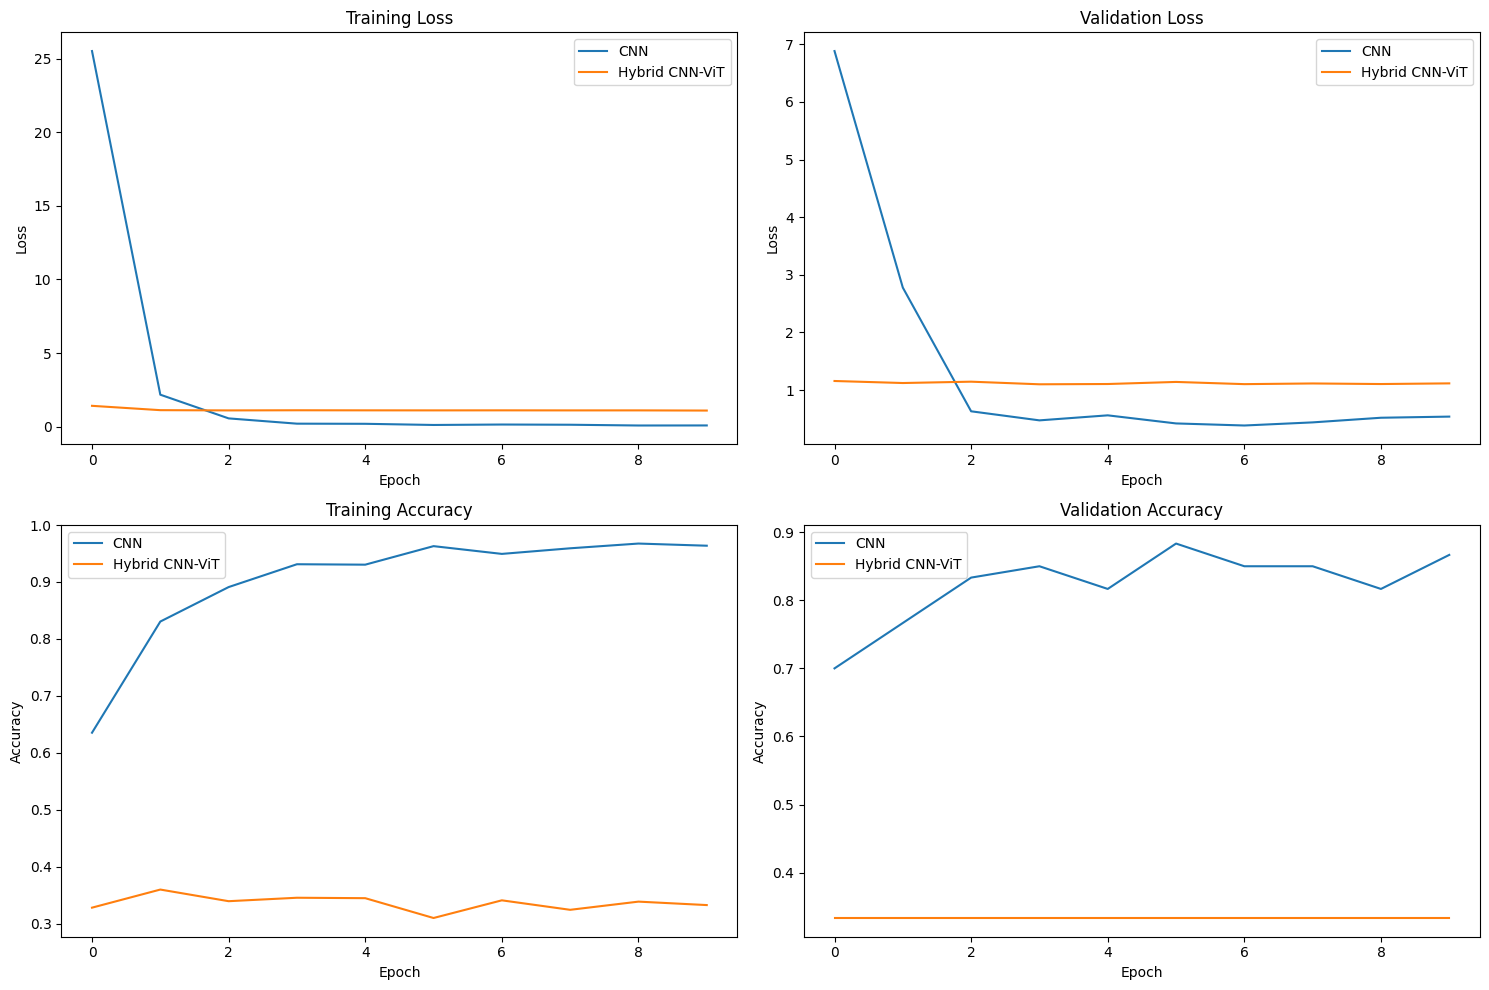

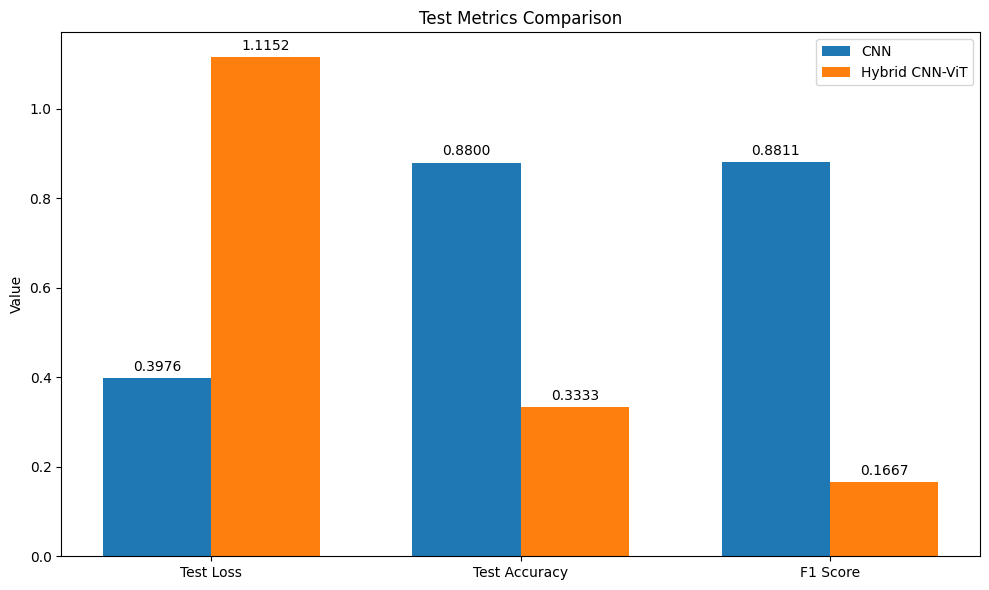


Model Comparison Results:
--------------------------------------------------------------------------------
Metric          | CNN             | Hybrid CNN-ViT  | Improvement    
--------------------------------------------------------------------------------
train_loss      | 0.0893          | 1.1001          | -1132.37       %
train_acc       | 0.9637          | 0.3328          | -65.46         %
val_loss        | 0.5383          | 1.1152          | -107.18        %
val_acc         | 0.8667          | 0.3333          | -61.54         %
test_loss       | 0.3976          | 1.1152          | -180.50        %
test_acc        | 0.8800          | 0.3333          | -62.12         %
f1_score        | 0.8811          | 0.1667          | -81.08         %
--------------------------------------------------------------------------------


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import random
from torchvision.datasets import ImageFolder
from torch.amp import GradScaler, autocast

# Set random seeds for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# Define the hybrid CNN-ViT model
class CNNViTHybrid(nn.Module):
    def __init__(self, num_classes=3, patch_size=16, hidden_dim=768, num_heads=8, num_layers=12):
        super(CNNViTHybrid, self).__init__()

        # CNN Feature Extraction Layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the size of feature maps after CNN layers
        # Assuming input size is 224x224
        feature_size = 224 // (2**3)  # After 3 pooling layers
        self.feature_dim = 128 * feature_size * feature_size

        # Vision Transformer Components
        self.patch_size = patch_size
        self.hidden_dim = hidden_dim

        # Linear projection of flattened patches
        self.patch_embedding = nn.Linear(128 * patch_size * patch_size, hidden_dim)

        # Position embeddings
        self.num_patches = (feature_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(torch.zeros(1, self.num_patches, hidden_dim))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 4,
            dropout=0.1,
            activation='gelu',
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classification head
        self.norm = nn.LayerNorm(hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # CNN Feature Extraction
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Conv1 + BN + ReLU + Pool
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Conv2 + BN + ReLU + Pool
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # Conv3 + BN + ReLU + Pool

        # Reshape for patch embedding
        batch_size, channels, h, w = x.shape

        # Ensure h and w are divisible by patch_size
        h_patches = h // self.patch_size
        w_patches = w // self.patch_size

        # Reshape to patches
        x = x.view(batch_size, channels, h_patches, self.patch_size, w_patches, self.patch_size)
        x = x.permute(0, 2, 4, 1, 3, 5).contiguous()
        x = x.view(batch_size, h_patches * w_patches, channels * self.patch_size * self.patch_size)

        # Linear embedding of patches
        x = self.patch_embedding(x)

        # Add position embeddings
        x = x + self.pos_embedding[:, :x.size(1), :]

        # Apply transformer encoder
        x = self.transformer_encoder(x)

        # Global average pooling over patches
        x = x.mean(dim=1)

        # Layer normalization and classification
        x = self.norm(x)
        x = self.fc(x)

        return x

# Define a simple CNN model for comparison
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    scaler = GradScaler('cuda')  # Updated syntax for mixed precision training

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    # for epoch in range(num_epochs):
    #     # Training phase
    #     model.train()
    #     running_loss = 0.0
    #     correct = 0
    #     total = 0

    #     for inputs, labels in train_loader:
    #         inputs, labels = inputs.to(device), labels.to(device)

    #         optimizer.zero_grad()

    #         outputs = model(inputs)
    #         loss = criterion(outputs, labels)
    #         loss.backward()
    #         optimizer.step()
    # for epoch in range(num_epochs):
    #     # Training phase
    #     model.train()
    #     running_loss = 0.0
    #     correct = 0
    #     total = 0

    #     for inputs, labels in train_loader:
    #         inputs, labels = inputs.to(device), labels.to(device)

    #         optimizer.zero_grad()

    #         # Use mixed precision training
    #         with autocast():
    #             outputs = model(inputs)
    #             loss = criterion(outputs, labels)

    #         # Scale gradients and optimize
    #         scaler.scale(loss).backward()
    #         scaler.step(optimizer)
    #         scaler.update()
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Use mixed precision training with updated syntax
            with autocast('cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            # Scale gradients and optimize
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()


            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = correct / total
        val_losses.append(epoch_loss)
        val_accuracies.append(epoch_acc)

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}')
        print(f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}')
        print('-' * 40)

    return train_losses, train_accuracies, val_losses, val_accuracies

# Function to evaluate the model
def evaluate_model(model, test_loader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    running_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = running_loss / len(test_loader.dataset)
    test_acc = correct / total

    # Calculate F1 score (simplified for multi-class)
    from sklearn.metrics import f1_score
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, F1 Score: {f1:.4f}')

    return test_loss, test_acc, f1

# Function to compare CNN and Hybrid models
def compare_models(cnn_model, hybrid_model, train_loader, val_loader, test_loader):
    # Train and evaluate CNN model
    print("Training CNN model...")
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)
    cnn_train_losses, cnn_train_accs, cnn_val_losses, cnn_val_accs = train_model(
        cnn_model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

    print("\nEvaluating CNN model...")
    cnn_test_loss, cnn_test_acc, cnn_f1 = evaluate_model(cnn_model, test_loader, criterion)

    # Train and evaluate Hybrid model
    print("\nTraining Hybrid CNN-ViT model...")
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(hybrid_model.parameters(), lr=0.001)
    hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs = train_model(
        hybrid_model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

    print("\nEvaluating Hybrid CNN-ViT model...")
    hybrid_test_loss, hybrid_test_acc, hybrid_f1 = evaluate_model(hybrid_model, test_loader, criterion)

    # Plot comparison
    plt.figure(figsize=(15, 10))

    # Plot training loss
    plt.subplot(2, 2, 1)
    plt.plot(cnn_train_losses, label='CNN')
    plt.plot(hybrid_train_losses, label='Hybrid CNN-ViT')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot validation loss
    plt.subplot(2, 2, 2)
    plt.plot(cnn_val_losses, label='CNN')
    plt.plot(hybrid_val_losses, label='Hybrid CNN-ViT')
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training accuracy
    plt.subplot(2, 2, 3)
    plt.plot(cnn_train_accs, label='CNN')
    plt.plot(hybrid_train_accs, label='Hybrid CNN-ViT')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot validation accuracy
    plt.subplot(2, 2, 4)
    plt.plot(cnn_val_accs, label='CNN')
    plt.plot(hybrid_val_accs, label='Hybrid CNN-ViT')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig('model_comparison.png')
    plt.show()

    # Create a bar chart comparing test metrics
    metrics = ['Test Loss', 'Test Accuracy', 'F1 Score']
    cnn_values = [cnn_test_loss, cnn_test_acc, cnn_f1]
    hybrid_values = [hybrid_test_loss, hybrid_test_acc, hybrid_f1]

    x = np.arange(len(metrics))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, cnn_values, width, label='CNN')
    rects2 = ax.bar(x + width/2, hybrid_values, width, label='Hybrid CNN-ViT')

    ax.set_ylabel('Value')
    ax.set_title('Test Metrics Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    # Add values on top of bars
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.4f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()
    plt.savefig('test_metrics_comparison.png')
    plt.show()

    # Return results for comparison
    return {
        'cnn': {
            'train_loss': cnn_train_losses[-1],
            'train_acc': cnn_train_accs[-1],
            'val_loss': cnn_val_losses[-1],
            'val_acc': cnn_val_accs[-1],
            'test_loss': cnn_test_loss,
            'test_acc': cnn_test_acc,
            'f1_score': cnn_f1
        },
        'hybrid': {
            'train_loss': hybrid_train_losses[-1],
            'train_acc': hybrid_train_accs[-1],
            'val_loss': hybrid_val_losses[-1],
            'val_acc': hybrid_val_accs[-1],
            'test_loss': hybrid_test_loss,
            'test_acc': hybrid_test_acc,
            'f1_score': hybrid_f1
        }
    }

# Main execution
def main():
    # Set up data transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Define dataset paths
    data_dir = "/kaggle/input/plant-disease-recognition-dataset"
    train_dir = os.path.join(data_dir, "Train/Train")
    val_dir = os.path.join(data_dir, "Validation/Validation")
    test_dir = os.path.join(data_dir, "Test/Test")

    # Create datasets using ImageFolder
    train_dataset = ImageFolder(root=train_dir, transform=transform)
    val_dataset = ImageFolder(root=val_dir, transform=transform)
    test_dataset = ImageFolder(root=test_dir, transform=transform)

    # Print dataset information
    print(f"Number of training samples: {len(train_dataset)}")
    print(f"Number of validation samples: {len(val_dataset)}")
    print(f"Number of test samples: {len(test_dataset)}")
    print(f"Class names: {train_dataset.classes}")

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Initialize models
    num_classes = len(train_dataset.classes)  # Should be 3: Healthy, Powdery, Rust
    cnn_model = SimpleCNN(num_classes=num_classes)
    hybrid_model = CNNViTHybrid(num_classes=num_classes, patch_size=4, hidden_dim=256, num_heads=4, num_layers=4)

    # Compare models
    results = compare_models(cnn_model, hybrid_model, train_loader, val_loader, test_loader)

    # Print comparison table
    print("\nModel Comparison Results:")
    print("-" * 80)
    print(f"{'Metric':<15} | {'CNN':<15} | {'Hybrid CNN-ViT':<15} | {'Improvement':<15}")
    print("-" * 80)

    for metric in ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'test_loss', 'test_acc', 'f1_score']:
        cnn_val = results['cnn'][metric]
        hybrid_val = results['hybrid'][metric]

        # Calculate improvement (note: for loss, lower is better)
        if 'loss' in metric:
            improvement = (cnn_val - hybrid_val) / cnn_val * 100
        else:
            improvement = (hybrid_val - cnn_val) / cnn_val * 100

        print(f"{metric:<15} | {cnn_val:<15.4f} | {hybrid_val:<15.4f} | {improvement:<15.2f}%")

    print("-" * 80)

if __name__ == "__main__":
    main()

In [1]:
# Add this function to your code
def save_model(model, model_name, save_dir='/kaggle/working/models'):
    """
    Save the trained model to disk in Kaggle working directory

    Args:
        model: The trained model to save
        model_name: Name to use for the saved model file
        save_dir: Directory to save the model in
    """
    import os

    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    # Save the model state dictionary
    model_path = os.path.join(save_dir, f"{model_name}.pth")
    torch.save(model.state_dict(), model_path)

    # Save the entire model (alternative method)
    full_model_path = os.path.join(save_dir, f"{model_name}_full.pth")
    torch.save(model, full_model_path)

    print(f"Model saved to {model_path}")
    print(f"Full model saved to {full_model_path}")

    return model_path, full_model_path

# Function to save training history and results
def save_training_history(results, filename='/kaggle/working/training_results.json'):
    """
    Save training history and results to a JSON file in Kaggle working directory

    Args:
        results: Dictionary containing training results
        filename: Name of the file to save results to
    """
    import json

    # Convert any non-serializable objects to strings or numbers
    serializable_results = {}
    for model_type, metrics in results.items():
        serializable_results[model_type] = {}
        for metric, value in metrics.items():
            if isinstance(value, (int, float, str, bool, list)):
                serializable_results[model_type][metric] = value
            else:
                serializable_results[model_type][metric] = str(value)

    # Save to file
    with open(filename, 'w') as f:
        json.dump(serializable_results, f, indent=4)

    print(f"Training results saved to {filename}")

# Function to save plots
def save_plots(train_losses, train_accs, val_losses, val_accs, model_name, save_dir='/kaggle/working/plots'):
    """
    Save training and validation plots in Kaggle working directory

    Args:
        train_losses: List of training losses
        train_accs: List of training accuracies
        val_losses: List of validation losses
        val_accs: List of validation accuracies
        model_name: Name to use for the saved plot files
        save_dir: Directory to save the plots in
    """
    import os
    import matplotlib.pyplot as plt

    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    # Plot and save training/validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    loss_path = os.path.join(save_dir, f"{model_name}_loss.png")
    plt.savefig(loss_path)
    plt.close()

    # Plot and save training/validation accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    acc_path = os.path.join(save_dir, f"{model_name}_accuracy.png")
    plt.savefig(acc_path)
    plt.close()

    print(f"Plots saved to {save_dir}")

# Modify your compare_models function to save models, results, and plots after evaluation
def compare_models(cnn_model, hybrid_model, train_loader, val_loader, test_loader):
    # Train and evaluate CNN model
    print("Training CNN model...")
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)
    cnn_train_losses, cnn_train_accs, cnn_val_losses, cnn_val_accs = train_model(
        cnn_model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

    print("\nEvaluating CNN model...")
    cnn_test_loss, cnn_test_acc, cnn_f1 = evaluate_model(cnn_model, test_loader, criterion)

    # Save CNN model and plots
    print("\nSaving CNN model and plots...")
    cnn_model_path, _ = save_model(cnn_model, "cnn_plant_disease")
    save_plots(cnn_train_losses, cnn_train_accs, cnn_val_losses, cnn_val_accs, "cnn_plant_disease")

    # Train and evaluate Hybrid model
    print("\nTraining Hybrid CNN-ViT model...")
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(hybrid_model.parameters(), lr=0.001)
    hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs = train_model(
        hybrid_model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

    print("\nEvaluating Hybrid CNN-ViT model...")
    hybrid_test_loss, hybrid_test_acc, hybrid_f1 = evaluate_model(hybrid_model, test_loader, criterion)

    # Save Hybrid model and plots
    print("\nSaving Hybrid CNN-ViT model and plots...")
    hybrid_model_path, _ = save_model(hybrid_model, "hybrid_cnn_vit_plant_disease")
    save_plots(hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, "hybrid_cnn_vit_plant_disease")

    # Create and save comparison plots
    plt.figure(figsize=(15, 10))

    # Plot training loss
    plt.subplot(2, 2, 1)
    plt.plot(cnn_train_losses, label='CNN')
    plt.plot(hybrid_train_losses, label='Hybrid CNN-ViT')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot validation loss
    plt.subplot(2, 2, 2)
    plt.plot(cnn_val_losses, label='CNN')
    plt.plot(hybrid_val_losses, label='Hybrid CNN-ViT')
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training accuracy
    plt.subplot(2, 2, 3)
    plt.plot(cnn_train_accs, label='CNN')
    plt.plot(hybrid_train_accs, label='Hybrid CNN-ViT')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot validation accuracy
    plt.subplot(2, 2, 4)
    plt.plot(cnn_val_accs, label='CNN')
    plt.plot(hybrid_val_accs, label='Hybrid CNN-ViT')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig('/kaggle/working/model_comparison.png')
    plt.close()

    # Create a bar chart comparing test metrics
    metrics = ['Test Loss', 'Test Accuracy', 'F1 Score']
    cnn_values = [cnn_test_loss, cnn_test_acc, cnn_f1]
    hybrid_values = [hybrid_test_loss, hybrid_test_acc, hybrid_f1]

    x = np.arange(len(metrics))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, cnn_values, width, label='CNN')
    rects2 = ax.bar(x + width/2, hybrid_values, width, label='Hybrid CNN-ViT')

    ax.set_ylabel('Value')
    ax.set_title('Test Metrics Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    # Add values on top of bars
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.4f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()
    plt.savefig('/kaggle/working/test_metrics_comparison.png')
    plt.close()

    # Create results dictionary
    results = {
        'cnn': {
            'train_loss': cnn_train_losses[-1],
            'train_acc': cnn_train_accs[-1],
            'val_loss': cnn_val_losses[-1],
            'val_acc': cnn_val_accs[-1],
            'test_loss': cnn_test_loss,
            'test_acc': cnn_test_acc,
            'f1_score': cnn_f1,
            'model_path': cnn_model_path
        },
        'hybrid': {
            'train_loss': hybrid_train_losses[-1],
            'train_acc': hybrid_train_accs[-1],
            'val_loss': hybrid_val_losses[-1],
            'val_acc': hybrid_val_accs[-1],
            'test_loss': hybrid_test_loss,
            'test_acc': hybrid_test_acc,
            'f1_score': hybrid_f1,
            'model_path': hybrid_model_path
        }
    }

    # Save results
    save_training_history(results)

    return results

# In your main function, make sure to call compare_models
def main():
    # ... existing code ...

    # Compare models (this will now save everything after training)
    results = compare_models(cnn_model, hybrid_model, train_loader, val_loader, test_loader)

    # Print comparison table
    print("\nModel Comparison Results:")
    print("-" * 80)
    print(f"{'Metric':<15} | {'CNN':<15} | {'Hybrid CNN-ViT':<15} | {'Improvement':<15}")
    print("-" * 80)

    for metric in ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'test_loss', 'test_acc', 'f1_score']:
        cnn_val = results['cnn'][metric]
        hybrid_val = results['hybrid'][metric]

        # Calculate improvement (note: for loss, lower is better)
        if 'loss' in metric:
            improvement = (cnn_val - hybrid_val) / cnn_val * 100
        else:
            improvement = (hybrid_val - cnn_val) / cnn_val * 100

        print(f"{metric:<15} | {cnn_val:<15.4f} | {hybrid_val:<15.4f} | {improvement:<15.2f}%")

    print("-" * 80)
    print(f"All models, plots, and results saved to /kaggle/working/")